In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 77 (delta 39), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (77/77), 10.91 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
pip install jcopdl==1.1.1

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12589 sha256=73d79bb296325b97a0ffc72d4ec8807c170ee55135d84de81005a08e14a94500
  Stored in directory: /root/.cache/pip/wheels/6d/46/c4/fbd4a6c344375a840af6eb98af862a0b12da406d4fbc2aa882
Successfully built jcopdl
Note: you may need to restart the kernel to use updated packages.


In [3]:
from jcopdl.layers import linear_block 
from jcopdl.callback import Callback

In [4]:
from earlystop import Earlystop

In [5]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [80]:
batch_size = 128
img_size = 224, 224

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/padi-data/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/padi-data/val', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [81]:
feature, label = next(iter(valloader))
print(feature.shape)

torch.Size([128, 3, 224, 224])


In [82]:
def ConvBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [83]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(
            
            ConvBlock(3, 16),
            nn.MaxPool2d(2,2),
            
            ConvBlock(16, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
                         
            ConvBlock(64, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 256),
            nn.MaxPool2d(2,2),
            
            ConvBlock(256, 512),
            nn.MaxPool2d(2,2),
            
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            linear_block(512*3*3, 256, activation='relu'),
            linear_block(256, output_size, activation='softmax')
        )
    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [84]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [85]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [86]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, scheduler, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)
        
        scheduler.step(test_cost)
        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-6)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=1)
callback = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 50

In [88]:
1.0016-0.9945

0.007099999999999995

Test: 100%|██████████| 3/3 [00:16<00:00,  5.49s/it]


Epoch 1: train_loss=1.3832, val_loss=1.3863, train_score=0.2913, val_score=0.2500


Test: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


Epoch 2: train_loss=1.3784, val_loss=1.3866, train_score=0.3254, val_score=0.2500
EarlyStop patience =  1. Best test_cost: 1.3863


Test: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


Epoch 3: train_loss=1.3736, val_loss=1.3860, train_score=0.3429, val_score=0.2722


Test: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


Epoch 4: train_loss=1.3681, val_loss=1.3824, train_score=0.4206, val_score=0.3583


Test: 100%|██████████| 3/3 [00:16<00:00,  5.41s/it]


Epoch 5: train_loss=1.3640, val_loss=1.3747, train_score=0.4429, val_score=0.4500


Test: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


Epoch 6: train_loss=1.3586, val_loss=1.3655, train_score=0.4667, val_score=0.5250


Test: 100%|██████████| 3/3 [00:15<00:00,  5.33s/it]


Epoch 7: train_loss=1.3525, val_loss=1.3581, train_score=0.5143, val_score=0.5417


Test: 100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


Epoch 8: train_loss=1.3481, val_loss=1.3516, train_score=0.5389, val_score=0.5500


Test: 100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


Epoch 9: train_loss=1.3425, val_loss=1.3456, train_score=0.5357, val_score=0.5667


Test: 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


Epoch 10: train_loss=1.3350, val_loss=1.3393, train_score=0.5905, val_score=0.5833


Test: 100%|██████████| 3/3 [00:15<00:00,  5.21s/it]


Epoch 11: train_loss=1.3272, val_loss=1.3327, train_score=0.5929, val_score=0.5833


Test: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


Epoch 12: train_loss=1.3197, val_loss=1.3248, train_score=0.6103, val_score=0.6083


Test: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


Epoch 13: train_loss=1.3135, val_loss=1.3171, train_score=0.6190, val_score=0.6111


Test: 100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


Epoch 14: train_loss=1.3041, val_loss=1.3082, train_score=0.6381, val_score=0.6250


Test: 100%|██████████| 3/3 [00:15<00:00,  5.21s/it]


Epoch 15: train_loss=1.2970, val_loss=1.2995, train_score=0.6421, val_score=0.6306


Test: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


Epoch 16: train_loss=1.2842, val_loss=1.2902, train_score=0.6548, val_score=0.6250


Test: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


Epoch 17: train_loss=1.2746, val_loss=1.2792, train_score=0.6635, val_score=0.6333


Test: 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


Epoch 18: train_loss=1.2637, val_loss=1.2677, train_score=0.6706, val_score=0.6278


Test: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


Epoch 19: train_loss=1.2518, val_loss=1.2563, train_score=0.6794, val_score=0.6333


Test: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


Epoch 20: train_loss=1.2338, val_loss=1.2441, train_score=0.6873, val_score=0.6361


Test: 100%|██████████| 3/3 [00:15<00:00,  5.33s/it]


Epoch 21: train_loss=1.2242, val_loss=1.2321, train_score=0.6944, val_score=0.6389


Test: 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


Epoch 22: train_loss=1.2100, val_loss=1.2189, train_score=0.7016, val_score=0.6500


Test: 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


Epoch 23: train_loss=1.1970, val_loss=1.2066, train_score=0.7056, val_score=0.6472


Test: 100%|██████████| 3/3 [00:15<00:00,  5.31s/it]


Epoch 24: train_loss=1.1825, val_loss=1.1945, train_score=0.7111, val_score=0.6472


Test: 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


Epoch 25: train_loss=1.1677, val_loss=1.1810, train_score=0.7206, val_score=0.6639


Test: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


Epoch 26: train_loss=1.1559, val_loss=1.1680, train_score=0.7175, val_score=0.6806


Test: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


Epoch 27: train_loss=1.1398, val_loss=1.1562, train_score=0.7278, val_score=0.6778


Test: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


Epoch 28: train_loss=1.1348, val_loss=1.1483, train_score=0.7175, val_score=0.6806


Test: 100%|██████████| 3/3 [00:15<00:00,  5.21s/it]


Epoch 29: train_loss=1.1194, val_loss=1.1362, train_score=0.7254, val_score=0.6861


Test: 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


Epoch 30: train_loss=1.1106, val_loss=1.1255, train_score=0.7222, val_score=0.6861


Test: 100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


Epoch 31: train_loss=1.1001, val_loss=1.1159, train_score=0.7238, val_score=0.6944


Test: 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


Epoch 32: train_loss=1.0907, val_loss=1.1068, train_score=0.7310, val_score=0.7056


Test: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


Epoch 33: train_loss=1.0850, val_loss=1.0998, train_score=0.7302, val_score=0.7028


Test: 100%|██████████| 3/3 [00:15<00:00,  5.21s/it]


Epoch 34: train_loss=1.0763, val_loss=1.0911, train_score=0.7310, val_score=0.7056


Test: 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


Epoch 35: train_loss=1.0678, val_loss=1.0812, train_score=0.7365, val_score=0.7194


Test: 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


Epoch 36: train_loss=1.0611, val_loss=1.0741, train_score=0.7357, val_score=0.7333


Test: 100%|██████████| 3/3 [00:15<00:00,  5.22s/it]


Epoch 37: train_loss=1.0565, val_loss=1.0661, train_score=0.7397, val_score=0.7472


Test: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


Epoch 38: train_loss=1.0464, val_loss=1.0602, train_score=0.7389, val_score=0.7528


Test: 100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


Epoch 39: train_loss=1.0396, val_loss=1.0517, train_score=0.7508, val_score=0.7583


Test: 100%|██████████| 3/3 [00:15<00:00,  5.30s/it]


Epoch 40: train_loss=1.0332, val_loss=1.0460, train_score=0.7603, val_score=0.7722


Test: 100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


Epoch 41: train_loss=1.0243, val_loss=1.0400, train_score=0.7778, val_score=0.7889


Test: 100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


Epoch 42: train_loss=1.0200, val_loss=1.0340, train_score=0.7802, val_score=0.8056


Test: 100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


Epoch 43: train_loss=1.0204, val_loss=1.0253, train_score=0.7794, val_score=0.8056


Test: 100%|██████████| 3/3 [00:15<00:00,  5.22s/it]


Epoch 44: train_loss=1.0143, val_loss=1.0210, train_score=0.7913, val_score=0.8167


Test: 100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


Epoch 45: train_loss=1.0086, val_loss=1.0174, train_score=0.7897, val_score=0.8250


Test: 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


Epoch 46: train_loss=1.0044, val_loss=1.0106, train_score=0.8024, val_score=0.8333


Test: 100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


Epoch 47: train_loss=0.9950, val_loss=1.0068, train_score=0.8127, val_score=0.8361


Test: 100%|██████████| 3/3 [00:16<00:00,  5.35s/it]


Epoch 48: train_loss=0.9885, val_loss=0.9991, train_score=0.8262, val_score=0.8556


Test: 100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


Epoch 49: train_loss=0.9907, val_loss=0.9928, train_score=0.8183, val_score=0.8583


Test: 100%|██████████| 3/3 [00:15<00:00,  5.31s/it]


Epoch 50: train_loss=0.9805, val_loss=0.9865, train_score=0.8365, val_score=0.8583


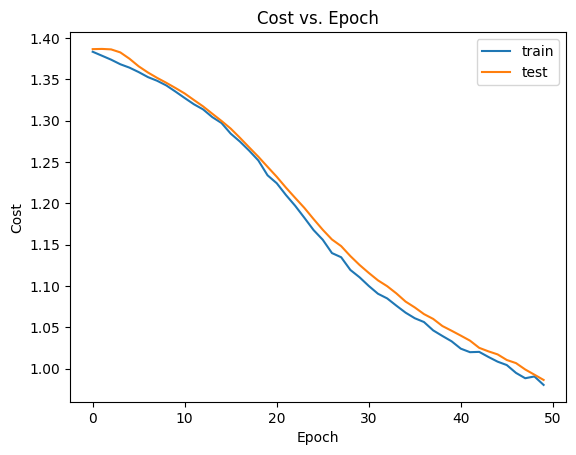

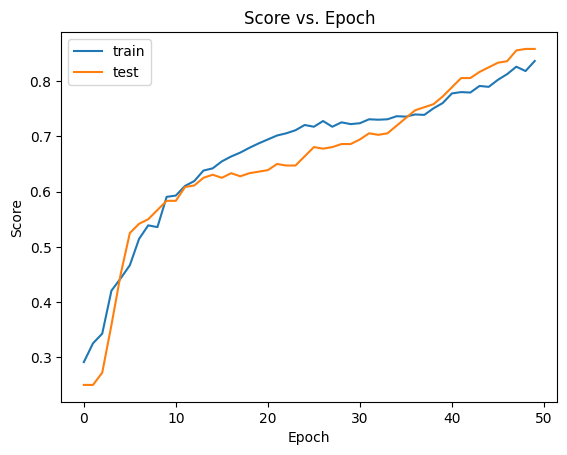

In [89]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device,scheduler, callback, epoch)

In [90]:
!pip install torchsummary

In [91]:
test_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/padi-data/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False)

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [93]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    
    class_counts_labels = np.bincount(all_labels)
    class_counts_predictions = np.bincount(all_predictions)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 1.0258, Test Accuracy: 0.8111
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.36      0.52        45
           1       0.84      0.91      0.87        45
           2       0.70      0.98      0.81        45
           3       0.88      1.00      0.94        45

    accuracy                           0.81       180
   macro avg       0.84      0.81      0.79       180
weighted avg       0.84      0.81      0.79       180

Confusion Matrix:


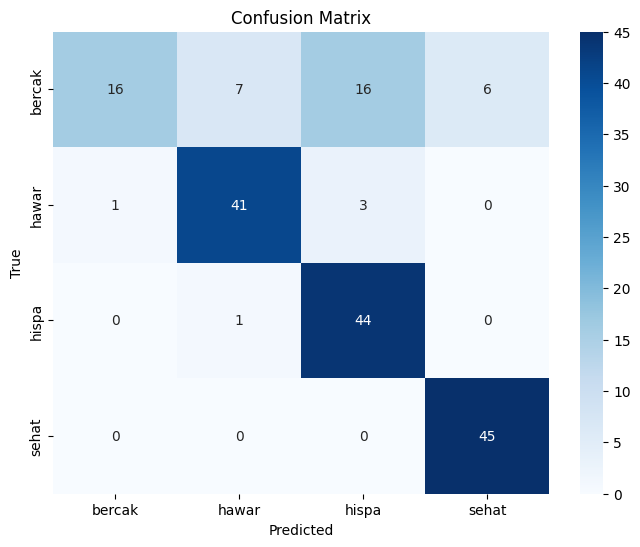

In [94]:
evaluate_model(model, testloader, criterion, device)

In [95]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [99]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))

model.feature[0][2].register_forward_hook(get_activation('relu'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))


img = Image.open('/kaggle/input/data-padi/test/bercak/IMG000000000013.jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

output = model(img_tensor)

/tmp/ipykernel_47/2727268787.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


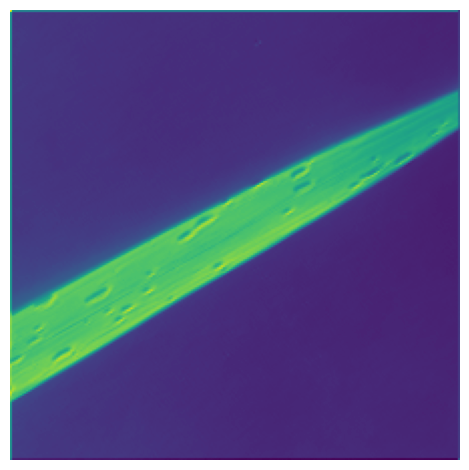

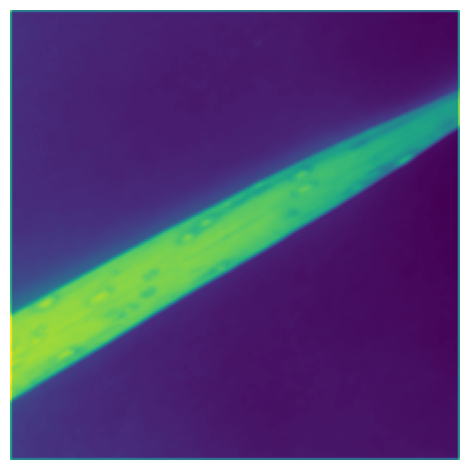

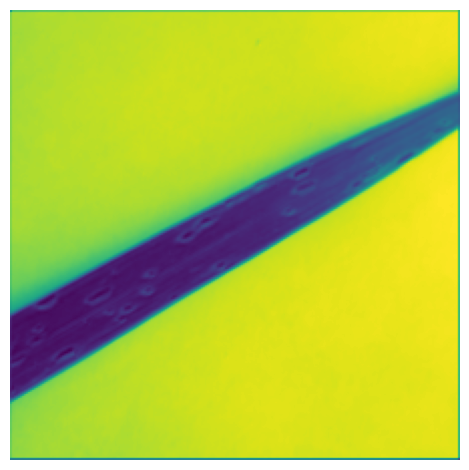

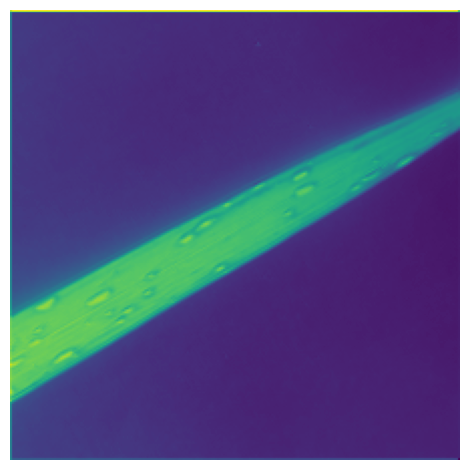

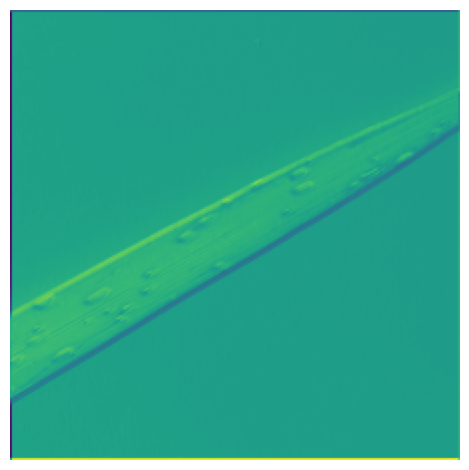

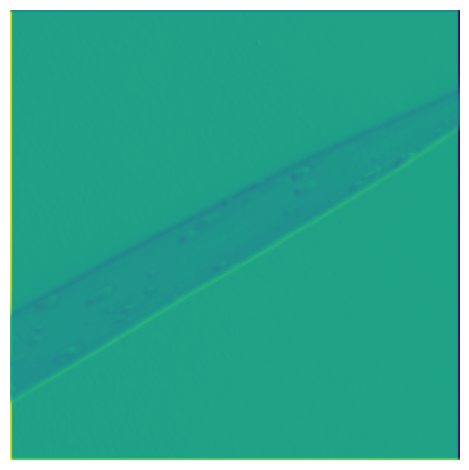

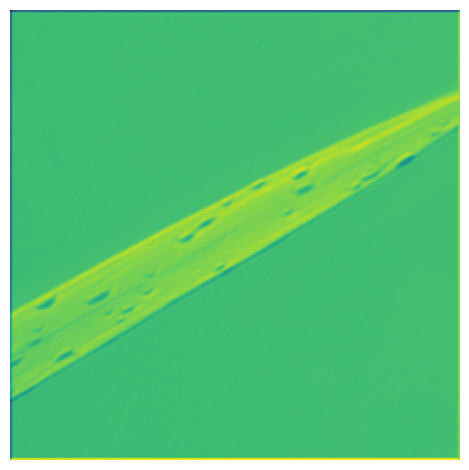

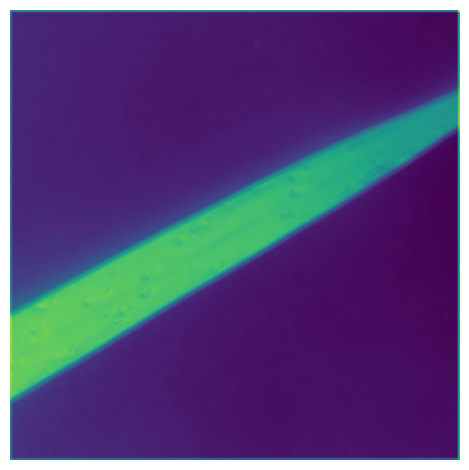

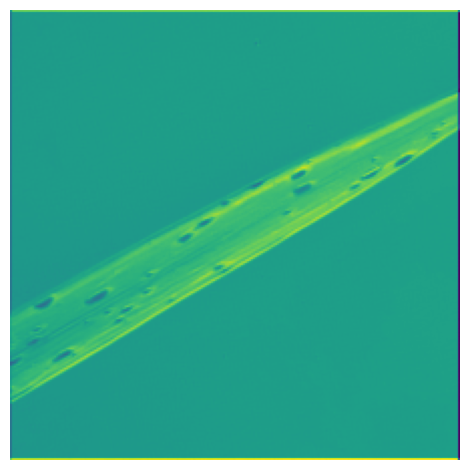

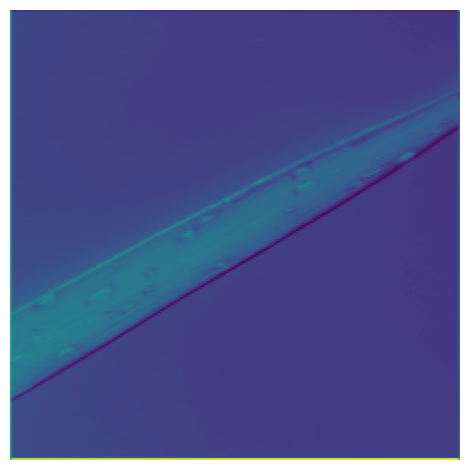

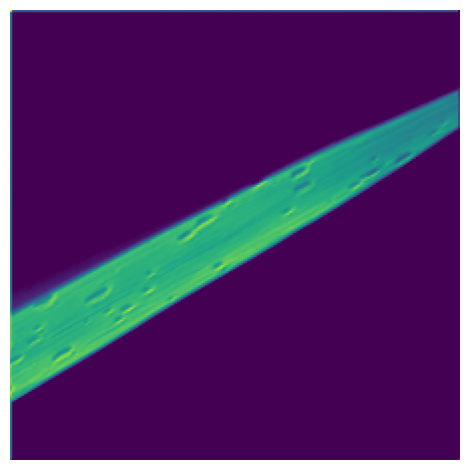

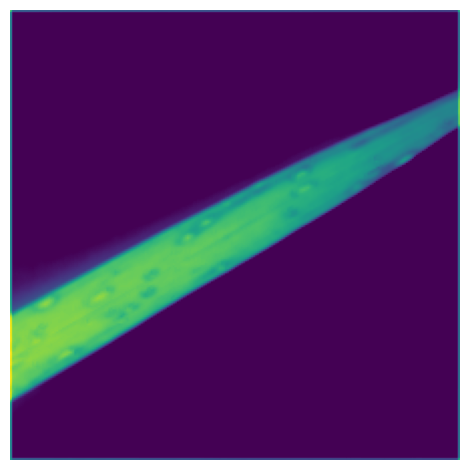

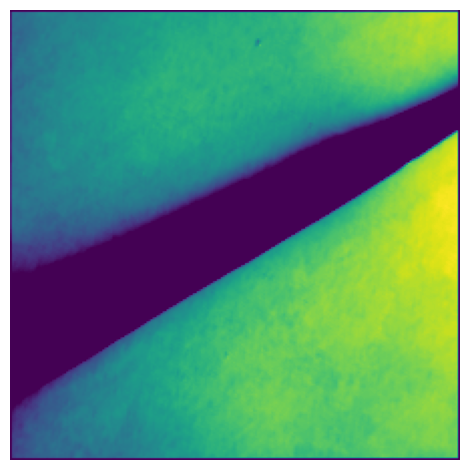

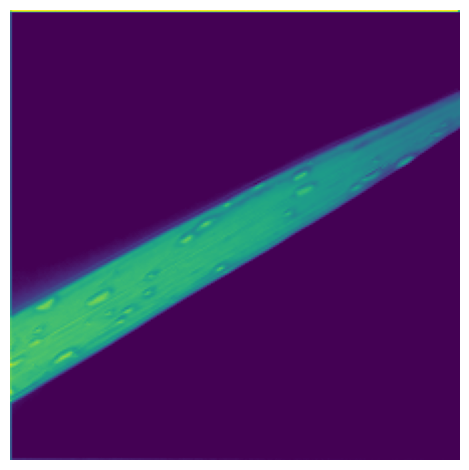

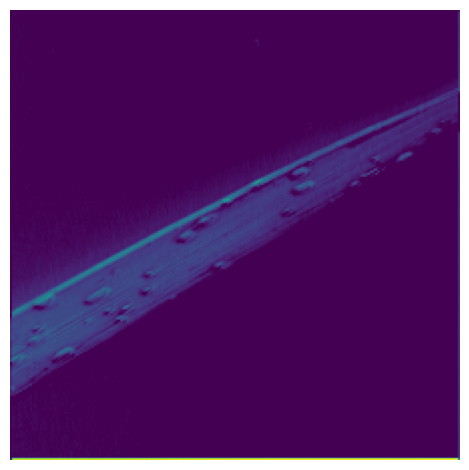

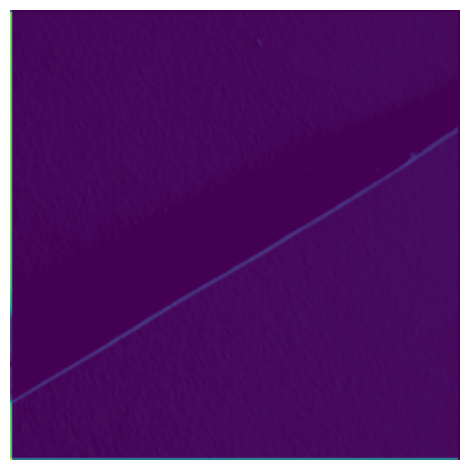

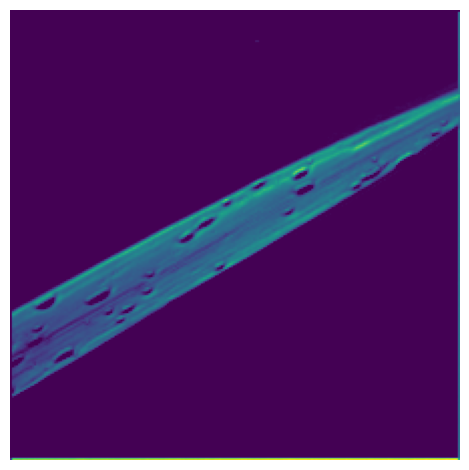

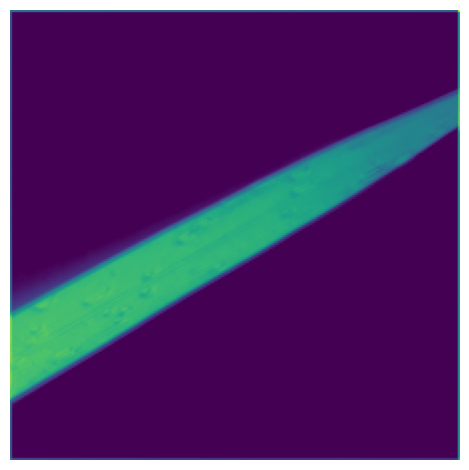

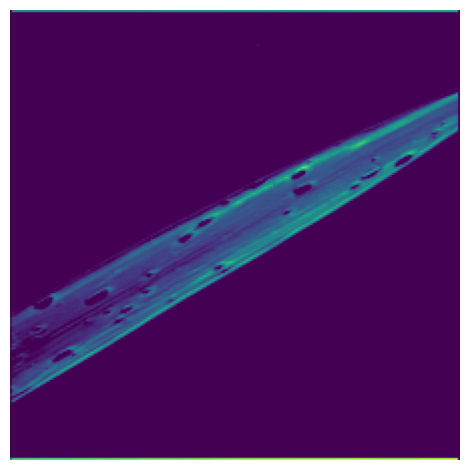

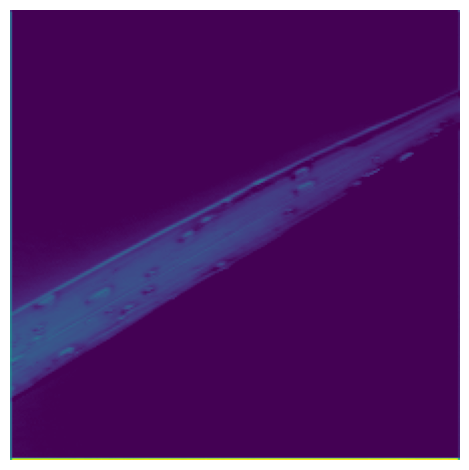

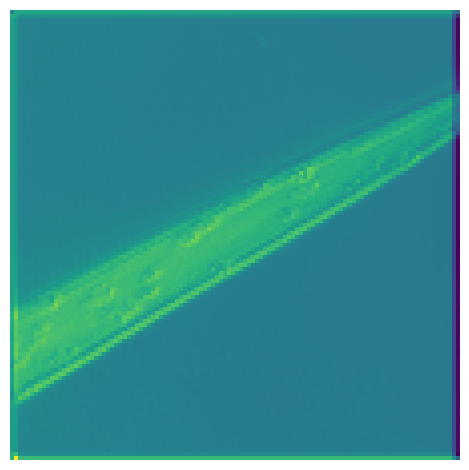

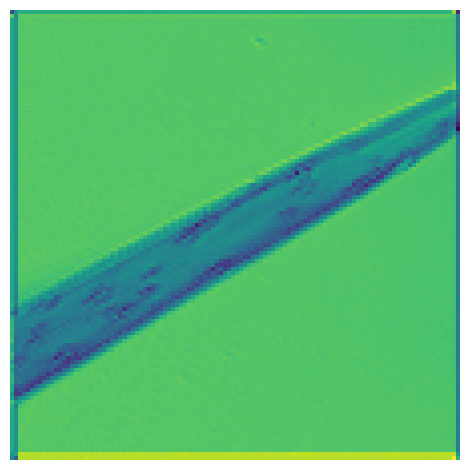

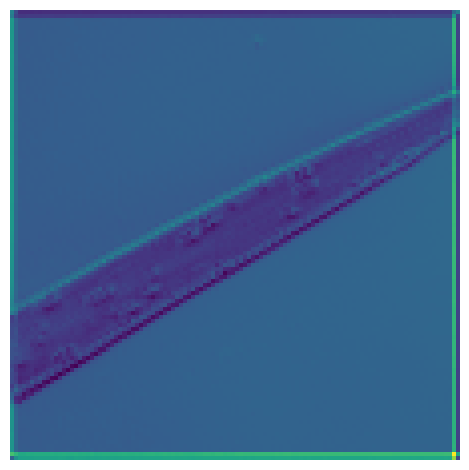

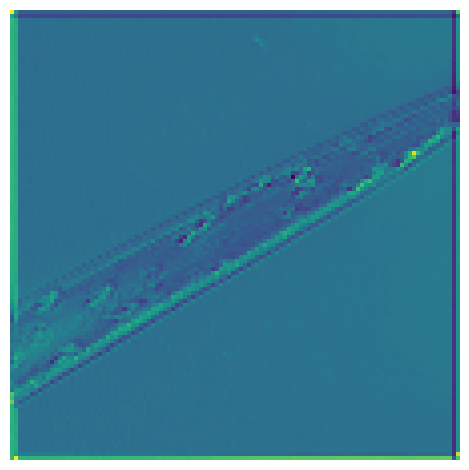

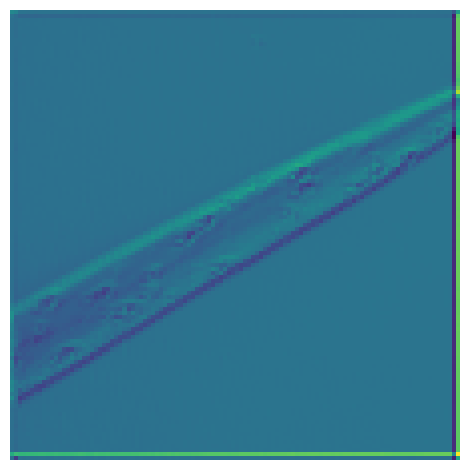

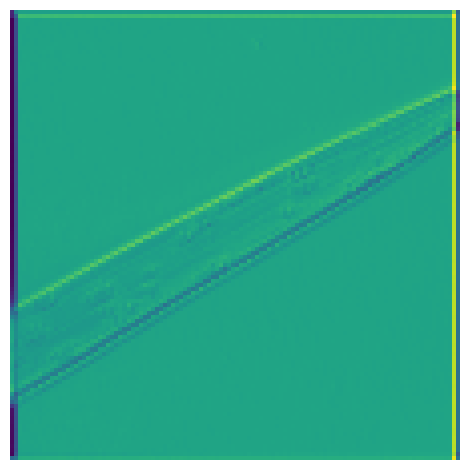

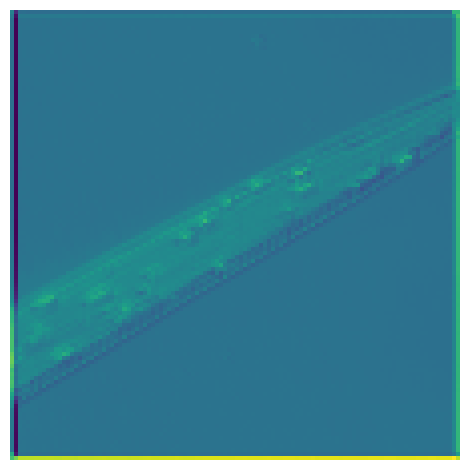

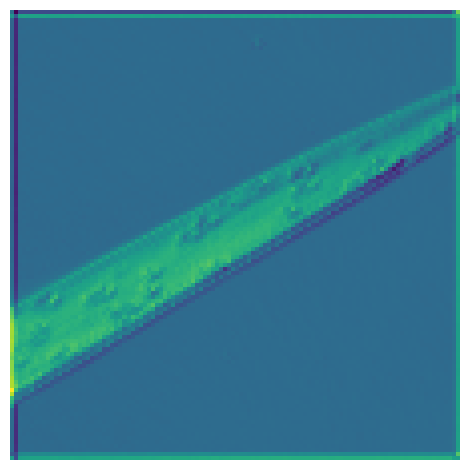

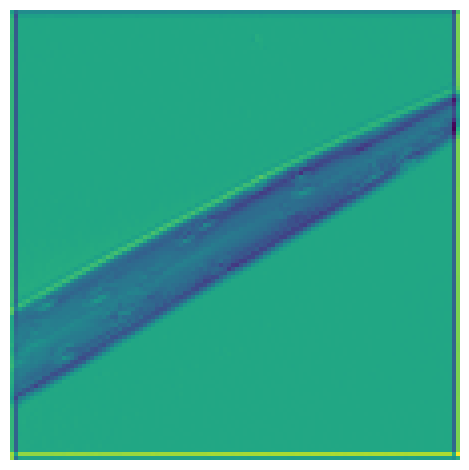

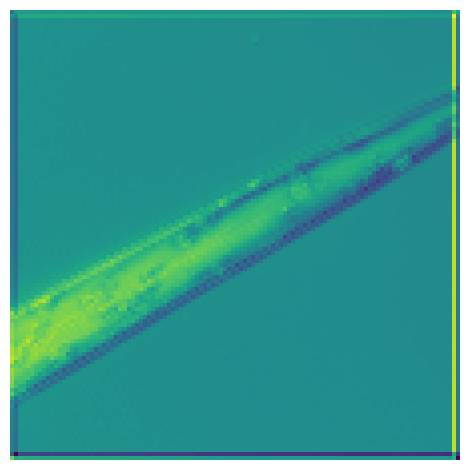

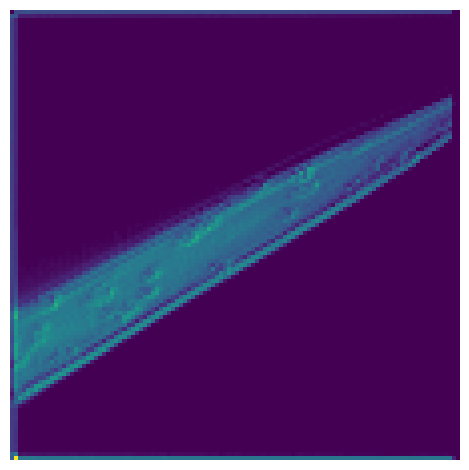

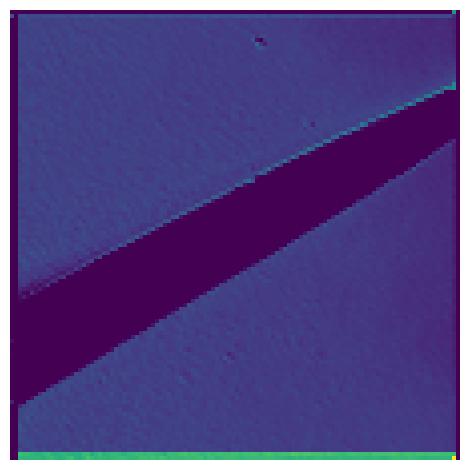

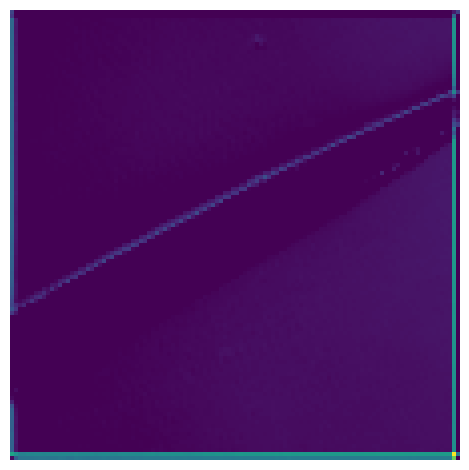

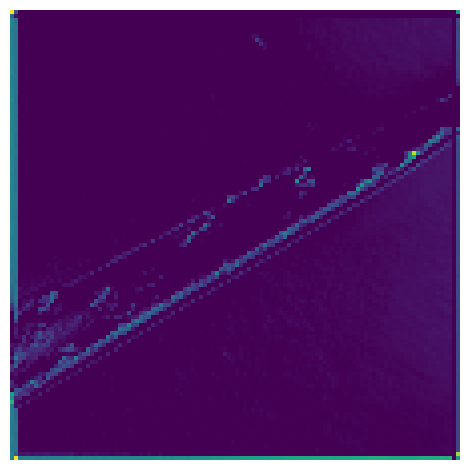

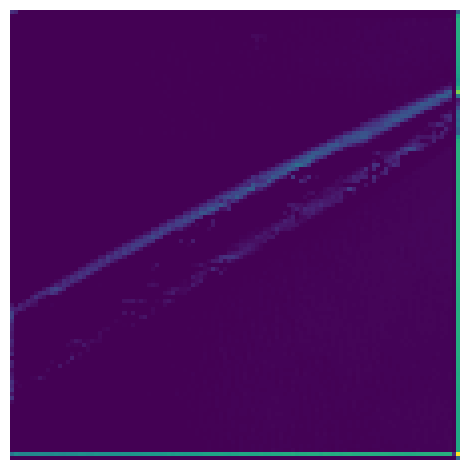

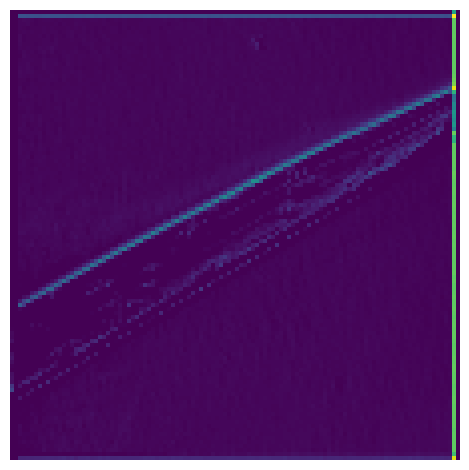

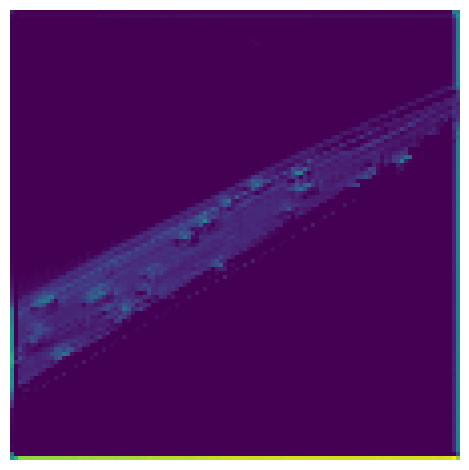

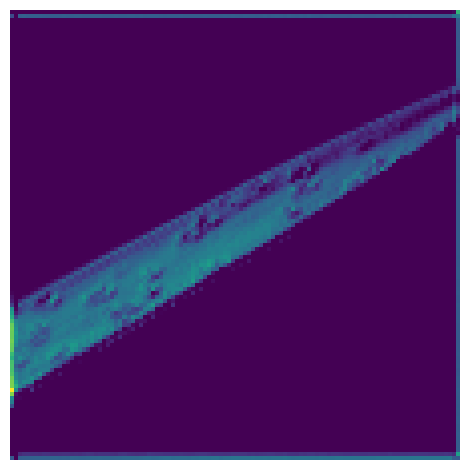

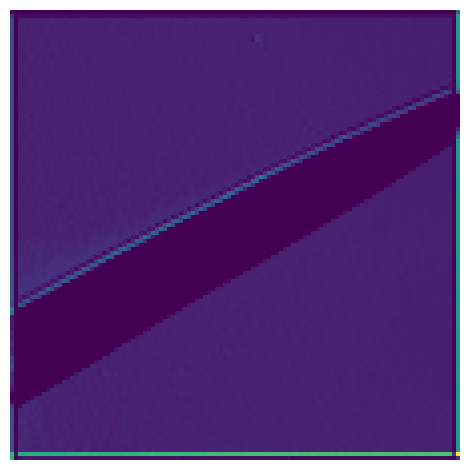

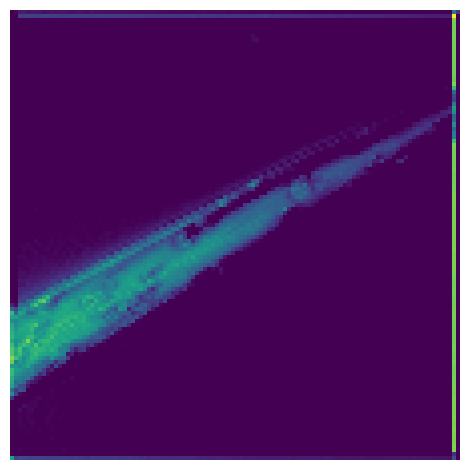

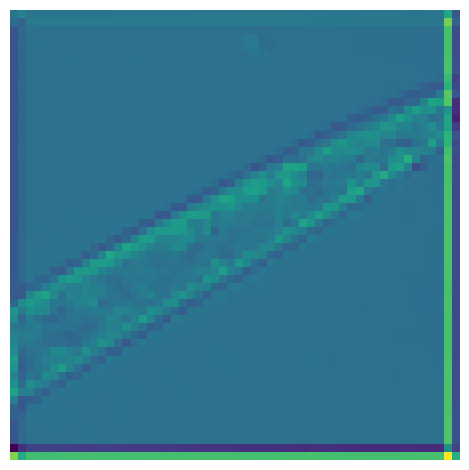

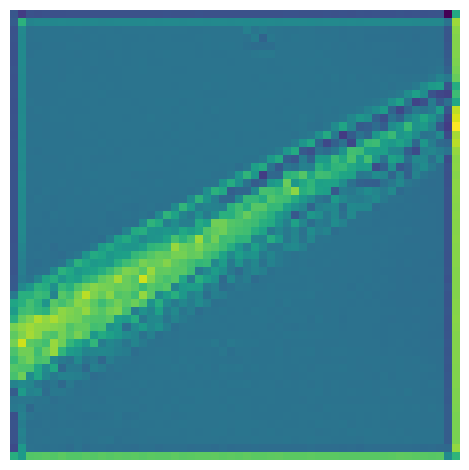

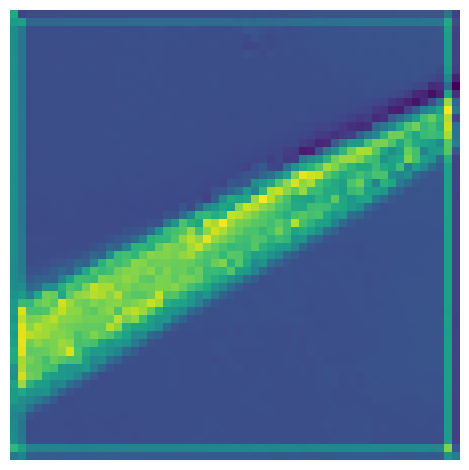

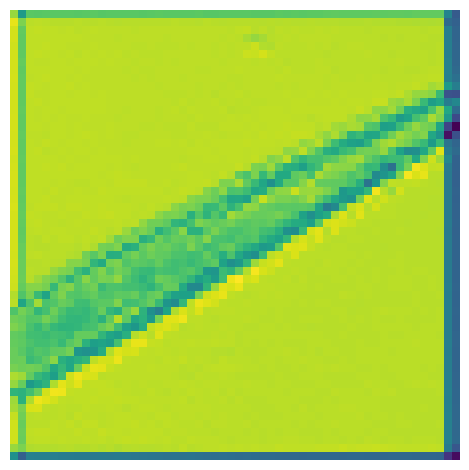

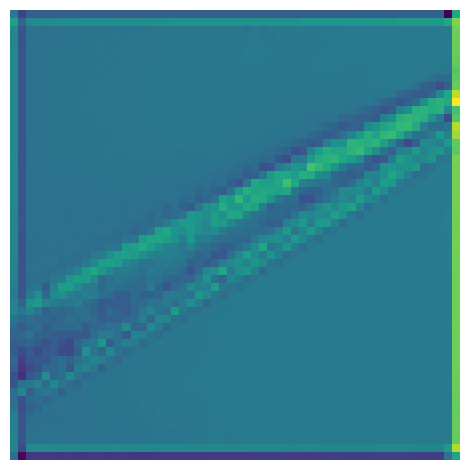

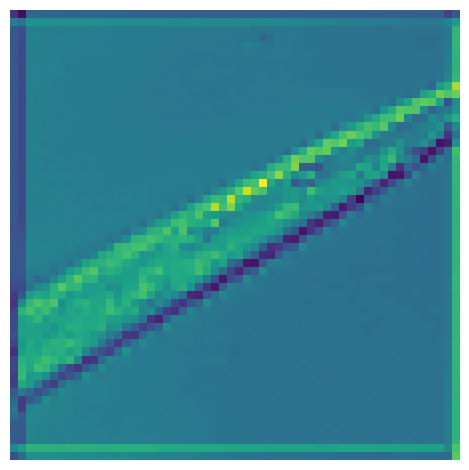

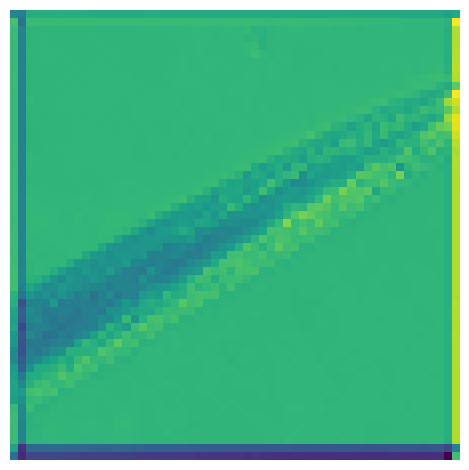

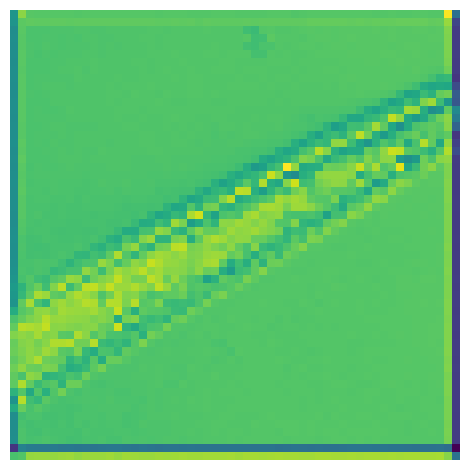

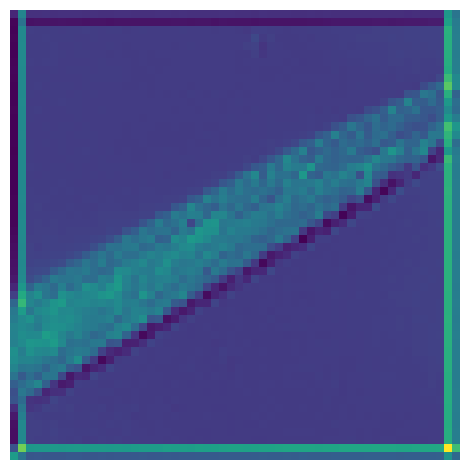

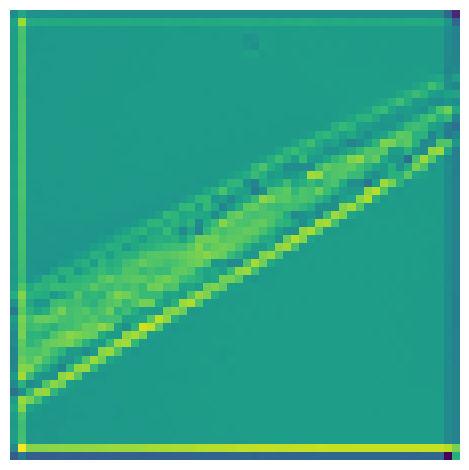

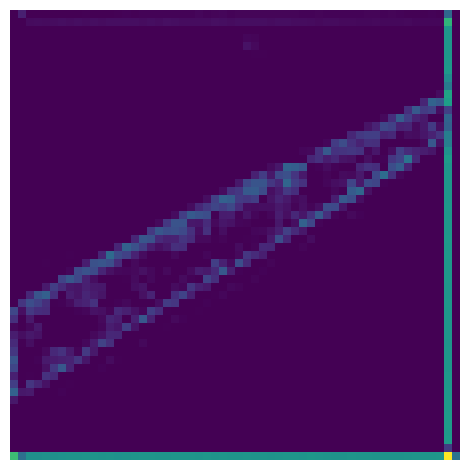

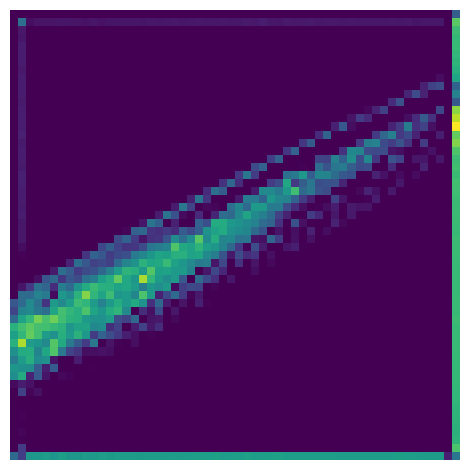

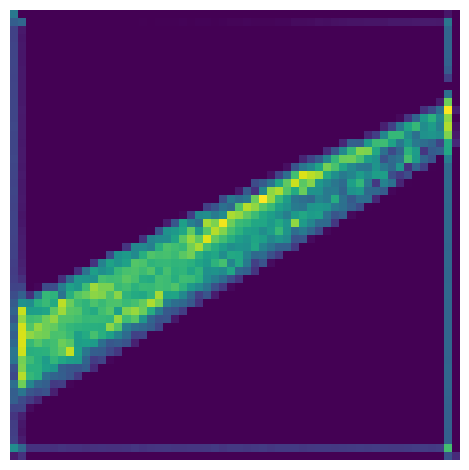

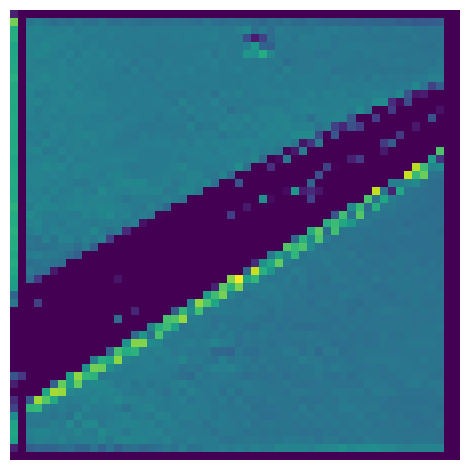

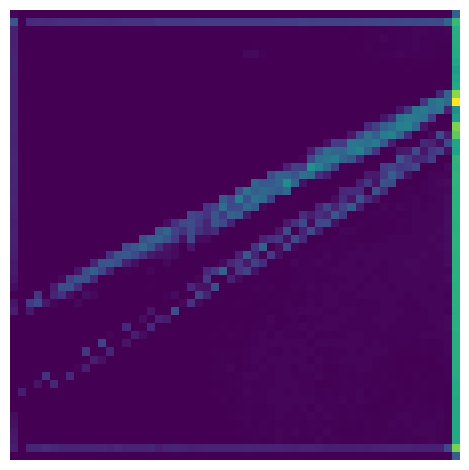

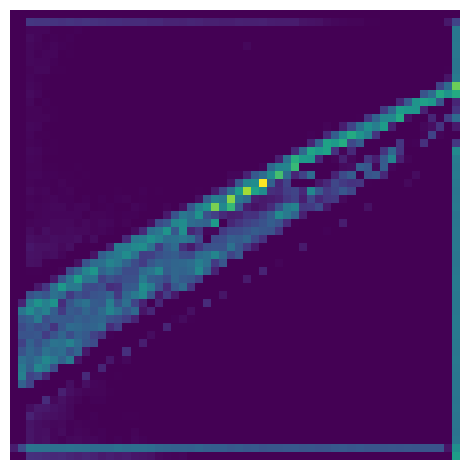

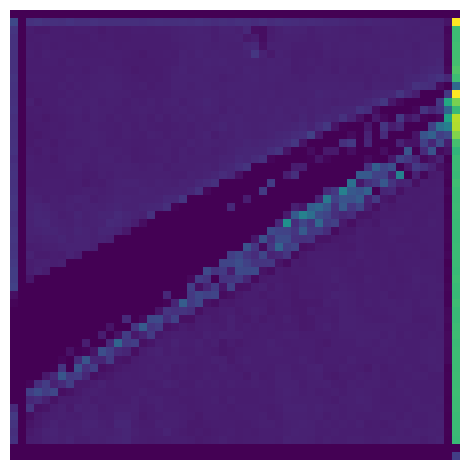

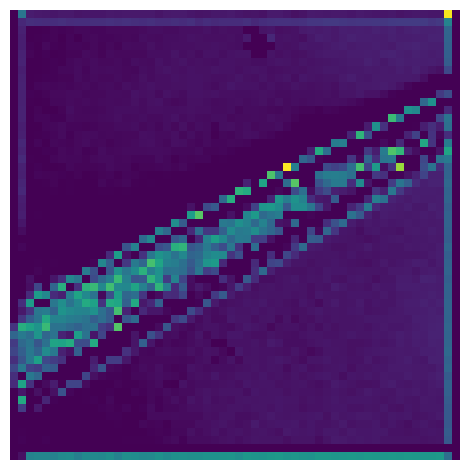

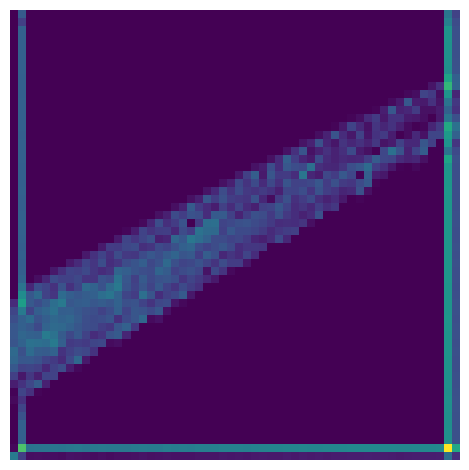

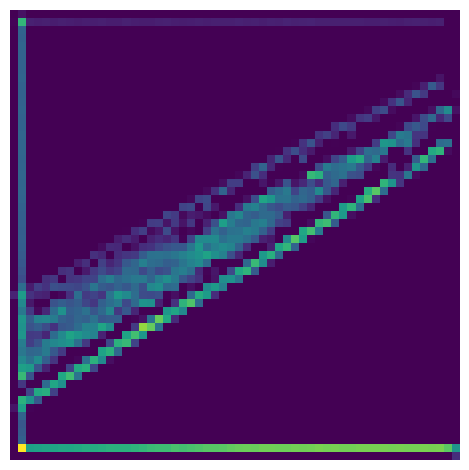

In [100]:
for name in activation1:
    folder_path = os.path.join('custom_12', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 1)
            ax.imshow(activation1[file][0, i].cpu().numpy())
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)


tensor([[[[1.0000, 0.9725, 0.7686, 0.9137, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7373, 0.8941, 1.0000, 1.0000],
          [1.0000, 0.9647, 0.7373, 0.8784, 1.0000, 1.0000],
          [1.0000, 0.9529, 0.7059, 0.8745, 1.0000, 1.0000],
          [1.0000, 0.9451, 0.6941, 0.8392, 0.9922, 1.0000],
          [1.0000, 0.9490, 0.6824, 0.7882, 0.9882, 1.0000]],

         [[1.0000, 0.9647, 0.7098, 0.8902, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7725, 0.8980, 1.0000, 1.0000],
          [1.0000, 0.9608, 0.7529, 0.8706, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.6902, 0.8627, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.7059, 0.8078, 0.9922, 1.0000],
          [1.0000, 0.9451, 0.6588, 0.7843, 0.9843, 1.0000]],

         [[1.0000, 0.9333, 0.4471, 0.7333, 1.0000, 1.0000],
          [1.0000, 0.9294, 0.4235, 0.6902, 1.0000, 1.0000],
          [1.0000, 0.9255, 0.4118, 0.6431, 0.9922, 1.0000],
          [1.0000, 0.9216, 0.3882, 0.6039, 0.9882, 1.0000],
          [1.0000, 0.9176, 0.3608, 0

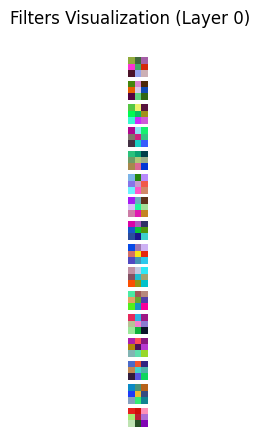

bias :tensor([-0.1625, -0.0684,  0.0772, -0.0298,  0.0924, -0.0352,  0.1698, -0.1218,
        -0.1007, -0.0894, -0.0183, -0.1594,  0.0283, -0.0517,  0.0459, -0.1010])


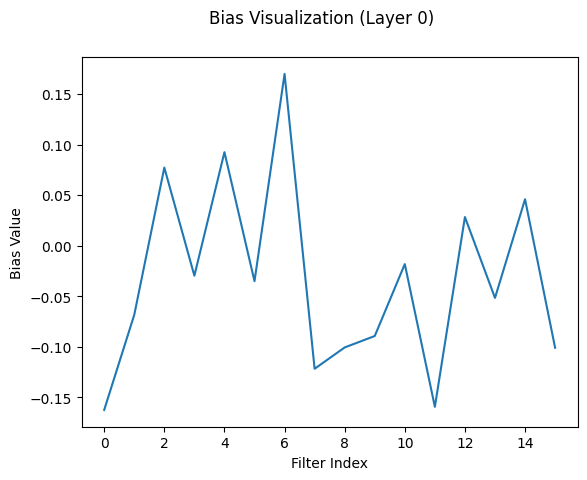

fitur :tensor([[[[ 1.1082e-01, -6.7872e-02, -1.4837e-01, -6.3700e-02, -4.0720e-02,
           -1.5692e-01],
          [-5.6894e-02, -2.6482e-01, -2.3695e-01, -1.8076e-01, -1.8974e-01,
           -3.8636e-01],
          [-5.9106e-02, -2.7759e-01, -2.3679e-01, -1.5669e-01, -1.8507e-01,
           -3.8637e-01],
          [-5.9145e-02, -2.7100e-01, -2.4785e-01, -1.6592e-01, -1.6728e-01,
           -3.8355e-01],
          [-5.9141e-02, -2.7308e-01, -2.4748e-01, -1.7643e-01, -1.5749e-01,
           -3.8097e-01],
          [-5.5757e-01, -2.7706e-01, -1.8089e-01, -3.4191e-01, -4.2641e-01,
           -2.6825e-01]],

         [[-4.4399e-02, -3.8331e-01, -5.8802e-01, -3.8326e-01, -4.1083e-01,
           -3.1263e-02],
          [-1.4130e-01, -6.1179e-01, -9.6744e-01, -6.9236e-01, -7.1236e-01,
           -1.6495e-02],
          [-1.3725e-01, -6.0726e-01, -9.6234e-01, -6.8642e-01, -6.9116e-01,
           -1.4411e-02],
          [-1.3083e-01, -5.9390e-01, -9.4548e-01, -6.9750e-01, -6.5610e-01,
      

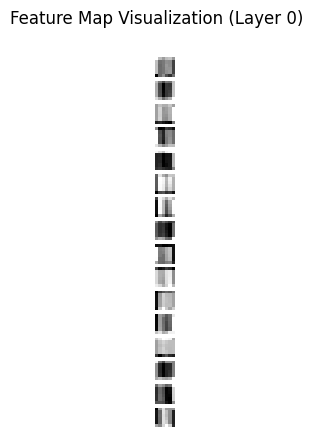

relu :tensor([[[[0.1108, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0907, 0.0000, 0.0000, 0.0000, 0.0000, 0.2739]],

         [[0.2468, 0.3352, 0.2831, 0.2804, 0.3453, 0.2477],
          [0.2484, 0.3844, 0.2162, 0.2409, 0.3003, 0.5030],
          [0.2475, 0.3764, 0.2241, 0.2335, 0.3008, 0.5024],
          [0.2474, 0.3722, 0.2174, 0.2137, 0.2868, 0.5016],
          [0.2517, 0.3865, 0.2

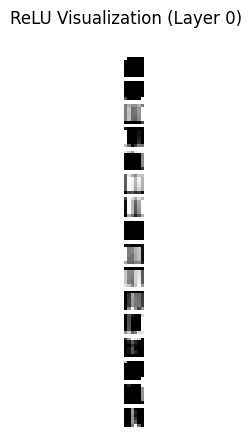

In [101]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)